##Introduction
In this notebook we demonstrate the Radiotherapy Outcomes Explorer (ROE)'s funcitonality to display tumor and normal tissue responses to changes in prescription dose.  

ROE is designed as a plugin to CERR and is available for download as a CERR module at https://github.com/cerr/CERR.git. This example demonstrates the potential for patient-specific prescription optimization by scaling fraction size.

##Requirements
* GNU Octave
* ROE (distributed with CERR)
* Matplotlib for visualization

Note: Installing these tools may incur a one-time extra runtime overhead.

##I/O
Below, we use  (1) structures and dose plans in CERR's native planC format (imported from DICOM) and  (2) sample dosimetric models and fractionation schemes distributed with ROE, in JSON format.

##Results
This notebook comes with a static visualization of sample dose-response plots.

### Install latest Octave from compile


In [ ]:
%%capture
! apt-get update
! apt-get install libgraphicsmagick++1-dev libsuitesparse-dev libqrupdate1 \
libfftw3-3 gnuplot zsh openjdk-8-jdk
! pip install oct2py octave_kernel

In [ ]:
import os, urllib.request, json

In [ ]:
%%capture
# Download compiled octave package (latest)
def geOctave(root_path):
  os.chdir(root_path)
  with urllib.request.urlopen("https://api.github.com/repos/cerr/octave-colab/releases/latest") as url:
      data = json.loads(url.read().decode())
  fname = data['assets'][0]['name']
  requrl = data['assets'][0]['browser_download_url']
  urllib.request.urlretrieve(requrl, fname)
  # unzip, identify octave folder name
  !tar xf {fname}
  top_folder = !tar tf {fname} | head -1
  octave_folder = top_folder[0][:-1]
  octave_path = os.path.join(root_path,octave_folder)
  return octave_path

octave_path = geOctave('/content')
os.environ['OCTAVE_EXECUTABLE'] = octave_path + '/bin/octave-cli'
os.environ['PATH'] = octave_path + '/bin:' + os.environ['PATH']


### Download CERR

In [ ]:
%%capture
!git clone --single-branch --branch octave_dev https://www.github.com/cerr/CERR.git
%cd /content/CERR
!git checkout 7845fd065176509d671753fca6ed0014b57b80a3
%cd /content/

### Install Octave-Python bridge

In [ ]:
%%capture
! pip3 install octave_kernel
! pip3 install oct2py==5.3.0

%load_ext oct2py.ipython
from oct2py import octave

### Install required octave packages


In [ ]:
%%capture
%%octave
pkg load statistics
pkg load io

### Prepare sample dataset

**Load sample dataset**

In [ ]:
%%capture
%%octave

#Add CERR to path
cerrPath = '/content/CERR'
currDir = pwd;
cd(cerrPath)
addToPath2(cerrPath)
cd(currDir)

#Load test image 
parts = strsplit(getCERRPath, filesep);
CERR_dir = strjoin(parts(1:end-2), filesep);
sampleData = fullfile(CERR_dir,['Unit_Testing/data_for_cerr_tests/',...
                      'CERR_plans/lung_ex1_20may03.mat.bz2']);
planC = loadPlanC(sampleData, tempdir);
planC = updatePlanFields(planC);
planC = quality_assure_planC(sampleData, planC);

**Rename/create required input structures**

In [ ]:
%%capture
%%octave

indexS = planC{end};

#Rename GTV structure 
strC = {planC{indexS.structures}.structureName};
GTVstrIdx = getMatchingIndex('GTV1',strC,'EXACT');
planC{indexS.structures}(GTVstrIdx).structureName = 'GTV';

#Create LUNG_GTV structure
lungStrIdx = getMatchingIndex('total_lung',strC,'EXACT');
planC = createDifferenceStructure(lungStrIdx,GTVstrIdx,planC);
planC{indexS.structures}(end).structureName = 'Lung_GTV';

#Get list of available structures
strC = {planC{indexS.structures}.structureName};

### Evaluate TCP/NTCP models 

**Load model parameters**

In [ ]:
%%capture
%%octave

protocoleDefPath = '/content/CERR/CERR_core/PlanAnalysis/sampleFilesForROE/Protocols/Lung 4Gyx15.json';
modelDefPath = '/content/CERR/CERR_core/PlanAnalysis/sampleFilesForROE/Models';

#Read JSON description of protocol
protocolInfoS = loadjson(protocoleDefPath); #fullfile(),protocolListC{protocolIdx(p)}));
modelListC = fieldnames(protocolInfoS.models);
#Get list of associated models
numModels = numel(modelListC);
protocolS.modelFiles = '';
for m = 1:numModels
        #Get path to JSON description of model
        modelFPath = fullfile(modelDefPath,protocolInfoS.models.(modelListC{m}).modelFile);
        #Load model parameters from JSON
        protocolS.model{m} = loadjson(modelFPath);
end
protocolS.numFractions = protocolInfoS.numFractions;
protocolS.totalDose = protocolInfoS.totalDose;

# Add BED model
modelFPath = '/content/CERR/CERR_core/ModelImplementationLibrary/DosimetricModels/Models/Lung BED.json';
protocolS.model{numModels+1} = loadjson(modelFPath);
numModels = numModels+1;

**Scale dose plan to match user-input protocol**

In [ ]:
%%capture
%%octave

#Scale dose plan 
plnNum = 1;
prescribedDose = 80; #Test assuming 2Gy x 40
indexS = planC{end};

numFrxProtocol = protocolS.numFractions;
protDose = protocolS.totalDose;
dpfProtocol = protDose/numFrxProtocol;
dA = getDoseArray(plnNum,planC);
dAscale = protDose/prescribedDose;
dAscaled = dA * dAscale;

**Compute TCP & NTCPs at a range of dose scale factors**

In [1]:
%%capture
%%octave
TCPcount = 0;
NTCPcount = 0;
BEDcount = 0;
scaledTCPv = [];
scaledNTCPv = [];
scaledBEDv = [];
NTCPmodelListC = {};
TCPmodelListC = {};
BEDmodelListC = {};

#Loop over available models
for m = 1:numModels

        modelS = protocolS.model{m};

        #Get associated structure no.
        if ~isstruct(modelS.parameters.structures)
            #If model has no structure-specific parameters
            inputStruct = {modelS.parameters.structures};
        else
            inputStruct = fieldnames(modelS.parameters.structures);
        end
        strNum = getMatchingIndex(inputStruct, strC,'EXACT');

        #Read model parameters
        paramS = [modelS.parameters];
        paramS.numFractions.val = numFrxProtocol;
        paramS.frxSize.val = dpfProtocol;
        if isfield(modelS,'abRatio')
            abRatio = modelS.abRatio;
            paramS.abRatio.val = abRatio;
        end

        #Calc. DVH
        binWidth = 0.5;
        [dosesV,volsV] = getDVH(strNum,plnNum,planC);
        [doseBinsV,volHistV] = doseHist(dosesV,volsV,binWidth);

        # Scale dose bins by factors in [0.5,1.5] and compute corresponding TCP/NTCP
        xScaleV = linspace(0.5,1.5,99);
        scaledCPv = xScaleV * 0;

        if strcmp(modelS.type,'TCP')
             TCPcount = TCPcount + 1;
             TCPmodelListC{TCPcount} = modelS.name;
        elseif strcmp(modelS.type,'BED')
             BEDcount = BEDcount + 1;
             BEDmodelListC{BEDcount} = modelS.name;
        else
             NTCPcount = NTCPcount + 1;
             NTCPmodelListC{NTCPcount} = modelS.name;
        end

        #Loop over scale factors
        for n = 1 : numel(xScaleV)

                #Scale fraction size 
                scale = xScaleV(n);
                paramS.frxSize.val = scale*dpfProtocol;

                #Scale dose bins
                scaledDoseBinsC = {scale * doseBinsV};

                #Fractionation correction to match modelled datset
                correctedScaledDoseC = frxCorrectROE(modelS,...
                    strNum,numFrxProtocol,scaledDoseBinsC);
                volHistC = {volHistV};

                #Calc. TCP/NTCP
                if strcmp(modelS.type,'TCP')
                    scaledTCPv(n,TCPcount) = feval(modelS.function,...
                        paramS,correctedScaledDoseC,volHistC);
                elseif strcmp(modelS.type,'BED')
                    scaledBEDv(n,BEDcount) = feval(modelS.function,...
                        paramS,correctedScaledDoseC,volHistC);      
                else
                    scaledNTCPv(n,NTCPcount) = feval(modelS.function,...
                        paramS,correctedScaledDoseC,volHistC);
                end
        end
    

end

### Visualization

In [2]:
%octave_pull NTCPmodelListC TCPmodelListC BEDmodelListC dpfProtocol numFrxProtocol xScaleV scaledTCPv scaledNTCPv scaledBEDv

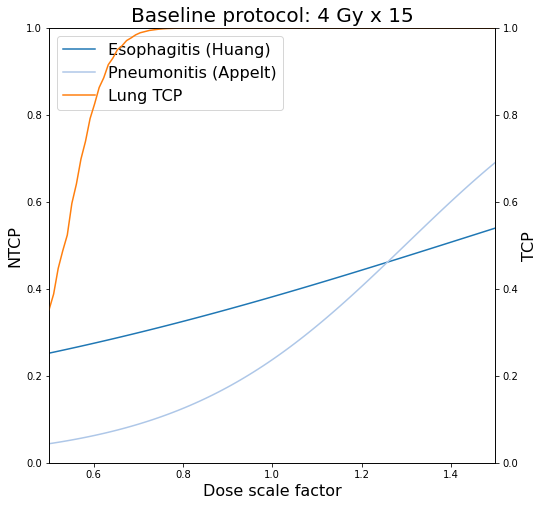

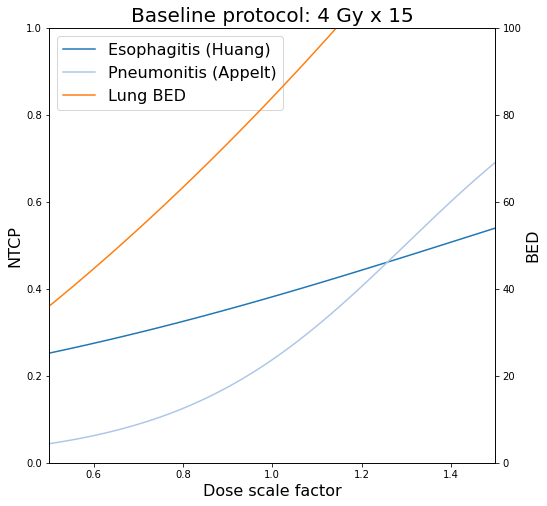

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import ipywidgets as widgets

def plotCurves(x,y1,y2,y2model,y2label,y2lim):

  colors = iter([plt.cm.tab20(i) for i in range(20)])

  # Create figure and axis objects 
  fig = plt.figure(figsize=(8,8))
  ax = plt.axes()
  sizeV = np.shape(y1)

  # Plot normal tissue response curves
  x1labels = NTCPmodelListC[0]
  labels = list()
  for model in range(sizeV[1]):
    scaledPredV = y1[:,model]
    scaledPredV = np.reshape(scaledPredV,(sizeV[0],1))
    x = np.reshape(x,(sizeV[0],1))
    plt.plot(x,scaledPredV,color=next(colors),label=x1labels[model])
    labels.append(x1labels[model])

  ax.set_xlim(x[0],x[-1])
  ax.set_ylim(0,1)

  # Plot tumor response curve
  ax2=ax.twinx()
  ax2.set_xlim(x[0],x[-1])
  ax2.set_ylim(y2lim)
  scaledPredV = y2[:,0]
  ax2.plot(x,scaledPredV,color=next(colors),label=y2model)

  # Label axes 
  ax.set_xlabel("Dose scale factor", fontsize = 16)
  ax.set_ylabel("NTCP",color="black",fontsize=16)
  ax2.set_ylabel(y2label,fontsize=16)

  # List models in legend
  h1, l1 = ax.get_legend_handles_labels()
  h2, l2 = ax2.get_legend_handles_labels()
  ax.legend(h1+h2, l1+l2, loc=2, fontsize=16)
  protocol = 'Baseline protocol: '+ str(int(dpfProtocol)) + \
  ' Gy x ' + str(int(numFrxProtocol)) 
  ax.set_title(protocol, fontsize=20)
 
  plt.show()

# Plot TCP, NTCP as a funcction of dose scale factor
plotCurves(xScaleV,scaledNTCPv,scaledTCPv,TCPmodelListC[0],'TCP',(0,1))
# Plot BED, NTCP as a funcction of dose scale factor
plotCurves(xScaleV,scaledNTCPv,scaledBEDv,BEDmodelListC[0],'BED',(0,100))
